<a href="https://colab.research.google.com/github/kbansal17/land_cover_land_use_lake_using_random_forest/blob/main/random_forest_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()
tif_files = list(uploaded.keys())
print("Uploaded files:", tif_files)

Saving Landsat_1990_Madurantakam.tif to Landsat_1990_Madurantakam.tif
Saving Landsat_2000_Madurantakam.tif to Landsat_2000_Madurantakam.tif
Saving Landsat_2010_Madurantakam.tif to Landsat_2010_Madurantakam.tif
Saving Sentinel2_2020_Madurantakam.tif to Sentinel2_2020_Madurantakam.tif
Uploaded files: ['Landsat_1990_Madurantakam.tif', 'Landsat_2000_Madurantakam.tif', 'Landsat_2010_Madurantakam.tif', 'Sentinel2_2020_Madurantakam.tif']


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1945
           1       1.00      1.00      1.00       404
           2       1.00      1.00      1.00      2499
           3       1.00      1.00      1.00        89

    accuracy                           1.00      4937
   macro avg       1.00      1.00      1.00      4937
weighted avg       1.00      1.00      1.00      4937



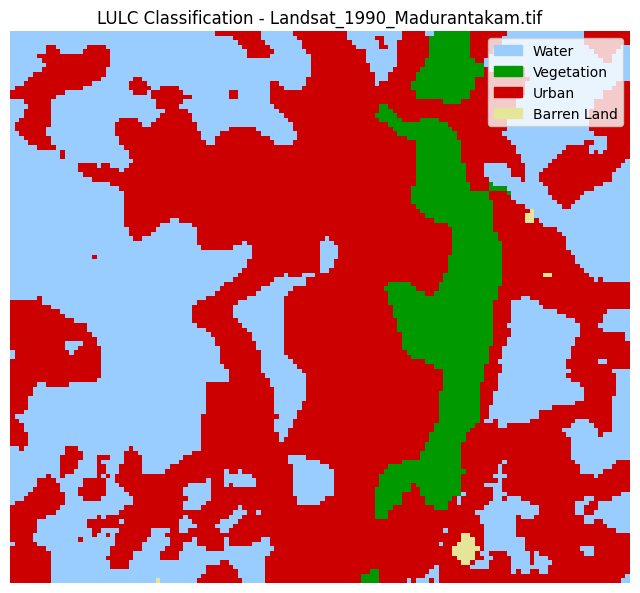

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       434
           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00      4303
           3       0.90      0.90      0.90        10

    accuracy                           1.00      4937
   macro avg       0.97      0.97      0.97      4937
weighted avg       1.00      1.00      1.00      4937



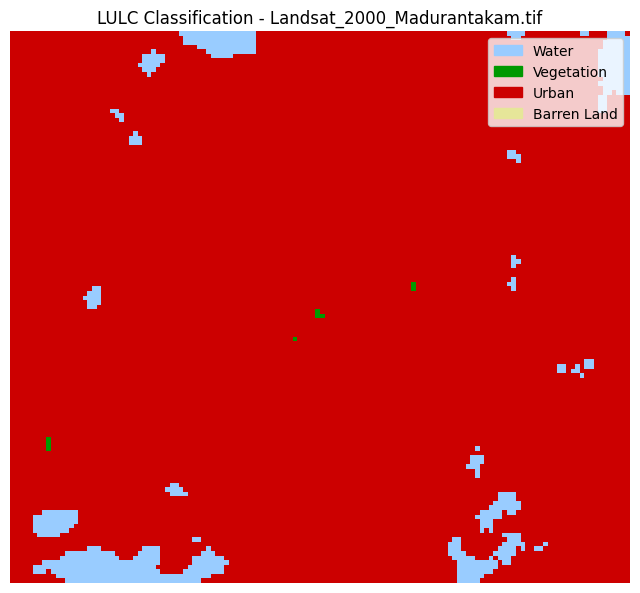

<ipython-input-11-f6be5a1ed640>:21: RuntimeWarning: invalid value encountered in divide
  return (nir_band - red_band) / (nir_band + red_band)
<ipython-input-11-f6be5a1ed640>:18: RuntimeWarning: invalid value encountered in divide
  return (green_band - nir_band) / (green_band + nir_band)
<ipython-input-11-f6be5a1ed640>:24: RuntimeWarning: invalid value encountered in divide
  return (swir_band - nir_band) / (swir_band + nir_band)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2258
           1       1.00      1.00      1.00       851
           2       1.00      1.00      1.00      1767
           3       1.00      0.98      0.99        61

    accuracy                           1.00      4937
   macro avg       1.00      1.00      1.00      4937
weighted avg       1.00      1.00      1.00      4937



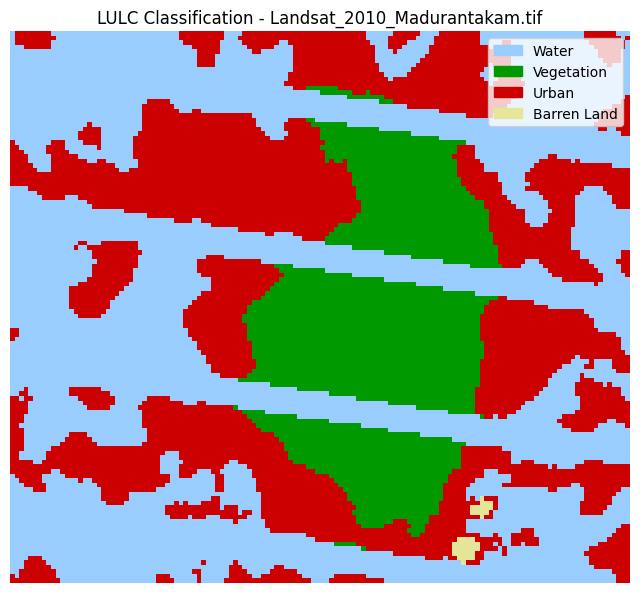

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1751
           1       1.00      1.00      1.00      2835
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00       234

    accuracy                           1.00      4901
   macro avg       1.00      1.00      1.00      4901
weighted avg       1.00      1.00      1.00      4901



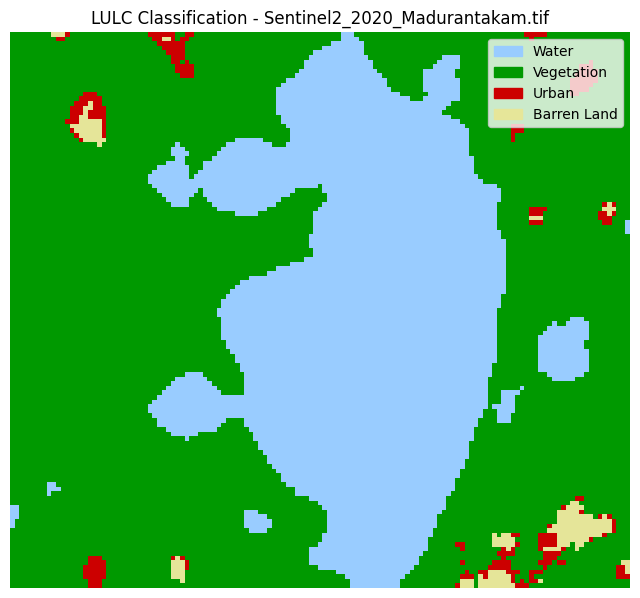

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import median
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.morphology import disk

# Step 2: Define Function to Load Images
def load_image(image_path):
    with rasterio.open(image_path) as dataset:
        bands = dataset.read()
    return bands

# Step 3: Calculate Spectral Indices
def calculate_ndwi(green_band, nir_band):
    return (green_band - nir_band) / (green_band + nir_band)

def calculate_ndvi(nir_band, red_band):
    return (nir_band - red_band) / (nir_band + red_band)

def calculate_ndbi(swir_band, nir_band):
    return (swir_band - nir_band) / (swir_band + nir_band)

# Step 4: Process Each Image for Features
def prepare_features(file_path):
    bands = load_image(file_path)
    green, red, nir, swir = bands[1], bands[2], bands[3], bands[4]  # Assuming Landsat band order

    # Calculate indices
    ndvi = calculate_ndvi(nir, red)
    ndwi = calculate_ndwi(green, nir)
    ndbi = calculate_ndbi(swir, nir)

    # Stack features for Random Forest input
    features = np.stack([green.ravel(), red.ravel(), nir.ravel(), swir.ravel(), ndvi.ravel(), ndwi.ravel(), ndbi.ravel()], axis=1)
    return features, bands[0].shape

# Step 5: Define Labels Based on Spectral Thresholds
def assign_labels(ndvi, ndwi, ndbi):
    labels = np.zeros(ndvi.shape, dtype=int)

    # Define class based on index thresholds
    labels[(ndwi > 0.3)] = 0  # Water
    labels[(ndvi > 0.4) & (ndwi <= 0.3)] = 1  # Vegetation
    labels[(ndbi > 0.1) & (ndvi < 0.3)] = 2  # Urban
    labels[(ndvi < 0.1) & (ndbi < 0.1)] = 3  # Barren Land

    return labels.ravel()

# Step 6: Random Forest Classification
def classify_image(features, labels):
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42, criterion='entropy')
    rf.fit(X_train, y_train)

    # Evaluate model
    y_pred = rf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Classify entire image
    classified_image = rf.predict(features)
    return classified_image

# Step 7: Visualize Results with Smoothing and Color Mapping
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_classified_image(classified_image, shape, title="LULC Classification"):
    # Reshape the classified image to match the original image shape
    lulc_map = classified_image.reshape(shape)

    # Apply median filter for smoothing
    lulc_map_smoothed = median(lulc_map, disk(3))  # Adjust smoothing as needed

    # Define custom distinct colors for each class
    color_map = {
        0: [0.6, 0.8, 1],    # Water (light blue)
        1: [0, 0.6, 0],      # Vegetation (dark green)
        2: [0.8, 0, 0],      # Urban (dark red)
        3: [0.9, 0.9, 0.6]   # Barren Land (beige)
    }

    # Map the classes to their corresponding colors
    color_image = np.zeros((lulc_map_smoothed.shape[0], lulc_map_smoothed.shape[1], 3))
    for label, color in color_map.items():
        color_image[lulc_map_smoothed == label] = color

    # Plot the classified image
    plt.figure(figsize=(8, 8))
    plt.imshow(color_image)
    plt.title(title)
    plt.axis('off')

    # Create a custom legend for the colors
    legend_handles = [
        mpatches.Patch(color=color_map[0], label='Water'),
        mpatches.Patch(color=color_map[1], label='Vegetation'),
        mpatches.Patch(color=color_map[2], label='Urban'),
        mpatches.Patch(color=color_map[3], label='Barren Land')
    ]

    plt.legend(handles=legend_handles, loc='upper right')
    plt.show()




# Step 8: Apply the Pipeline to Each Uploaded File
uploaded_files = ['Landsat_1990_Madurantakam.tif', 'Landsat_2000_Madurantakam.tif', 'Landsat_2010_Madurantakam.tif', 'Sentinel2_2020_Madurantakam.tif']

for file_name in uploaded_files:
    # Prepare features
    bands = load_image(file_name)
    green, red, nir, swir = bands[1], bands[2], bands[3], bands[4]
    ndvi = calculate_ndvi(nir, red)
    ndwi = calculate_ndwi(green, nir)
    ndbi = calculate_ndbi(swir, nir)

    # Assign labels using thresholds
    labels = assign_labels(ndvi, ndwi, ndbi)

    # Stack features and classify
    features = np.stack([green.ravel(), red.ravel(), nir.ravel(), swir.ravel(), ndvi.ravel(), ndwi.ravel(), ndbi.ravel()], axis=1)
    classified_image = classify_image(features, labels)

    # Visualize results
    plot_classified_image(classified_image, bands[0].shape, title=f"LULC Classification - {file_name}")
